# Chapter 2: End-to-End Machine Learning Project

## 📚 Assignment Summary

This notebook serves as the submission for **Chapter 2** of the book *"Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow."*

**Chapter Objective:** This chapter walks through an example project end-to-end, pretending to be a data scientist at a real estate company. The goal is to build a model of housing prices in California using census data.

This notebook will reproduce all the code from the chapter while also providing theoretical explanations for each step, as required by the assignment.

## 1. Look at the Big Picture

Before diving into the code, it's essential to understand the project's objectives.

### 1.1. Frame the Problem

The first task is to define the business objective. In this case, the model's output (a prediction of a district's median housing price) will be fed into another Machine Learning system to determine whether it's worth investing in a given area.

Based on this, we can frame the problem:
* **Supervised Learning:** Yes, because we are given labeled training examples (each instance has a known median housing price).
* **Regression Task:** Yes, because we are asked to predict a continuous numeric value (the median housing price). This is a *multiple regression* problem as we will use multiple features to make the prediction.
* **Batch Learning:** Yes, because there is no continuous flow of new data, and the dataset is small enough to fit in memory. Plain batch learning is fine.

### 1.2. Select a Performance Measure

A typical performance measure for regression problems is the **Root Mean Square Error (RMSE)**. It gives an idea of how much error the system typically makes in its predictions, with a higher weight given to large errors.

$$RMSE(\mathbf{X}, h) = \sqrt{\frac{1}{m} \sum_{i=1}^{m} (h(\mathbf{x}^{(i)}) - y^{(i)})^2}$$

If there are many outliers, we might prefer the **Mean Absolute Error (MAE)**:

$$MAE(\mathbf{X}, h) = \frac{1}{m} \sum_{i=1}^{m} |h(\mathbf{x}^{(i)}) - y^{(i)}|$$

For this project, we will use the RMSE.

## 2. Get the Data

Now, let's set up the workspace, download the data, and create the functions to load it.

In [1]:
# Common imports
import numpy as np
import pandas as pd
import os
import tarfile
import urllib.request
import matplotlib.pyplot as plt

# Setup for downloading the data
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """Creates the housing_path directory, downloads and extracts the .tgz file."""
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    """Loads the housing.csv file from the specified path using pandas."""
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [2]:
# Download and extract the data
fetch_housing_data()

# Load the data into a pandas DataFrame
housing = load_housing_data()

/tmp/ipython-input-2892564440.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


### 2.1. Take a Quick Look at the Data Structure

After loading the data, the first step is to inspect it to understand its structure, features, and potential issues.

In [3]:
# Display the top 5 rows
print("Top 5 rows:")
display(housing.head())

# Get a quick description of the data (total rows, attributes, non-null values)
print("\nData Info:")
housing.info()

Top 5 rows:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


#### 🧑‍🏫 Theoretical Deep-Dive: Data Inspection

From the `.info()` output, we can observe:
* There are 20,640 instances in the dataset.
* The `total_bedrooms` attribute has only 20,433 non-null values, meaning 207 districts are missing this feature. We will need to handle these missing values.
* All attributes are numerical, *except* `ocean_proximity`, which is an `object` type. This suggests it is a text-based categorical attribute.

In [4]:
# Find out what categories exist in 'ocean_proximity' and how many districts belong to each
print("\nOcean Proximity Categories:")
display(housing["ocean_proximity"].value_counts())


Ocean Proximity Categories:


,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [5]:
# Get a summary of the numerical attributes
print("\nNumerical Attribute Summary:")
display(housing.describe())


Numerical Attribute Summary:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


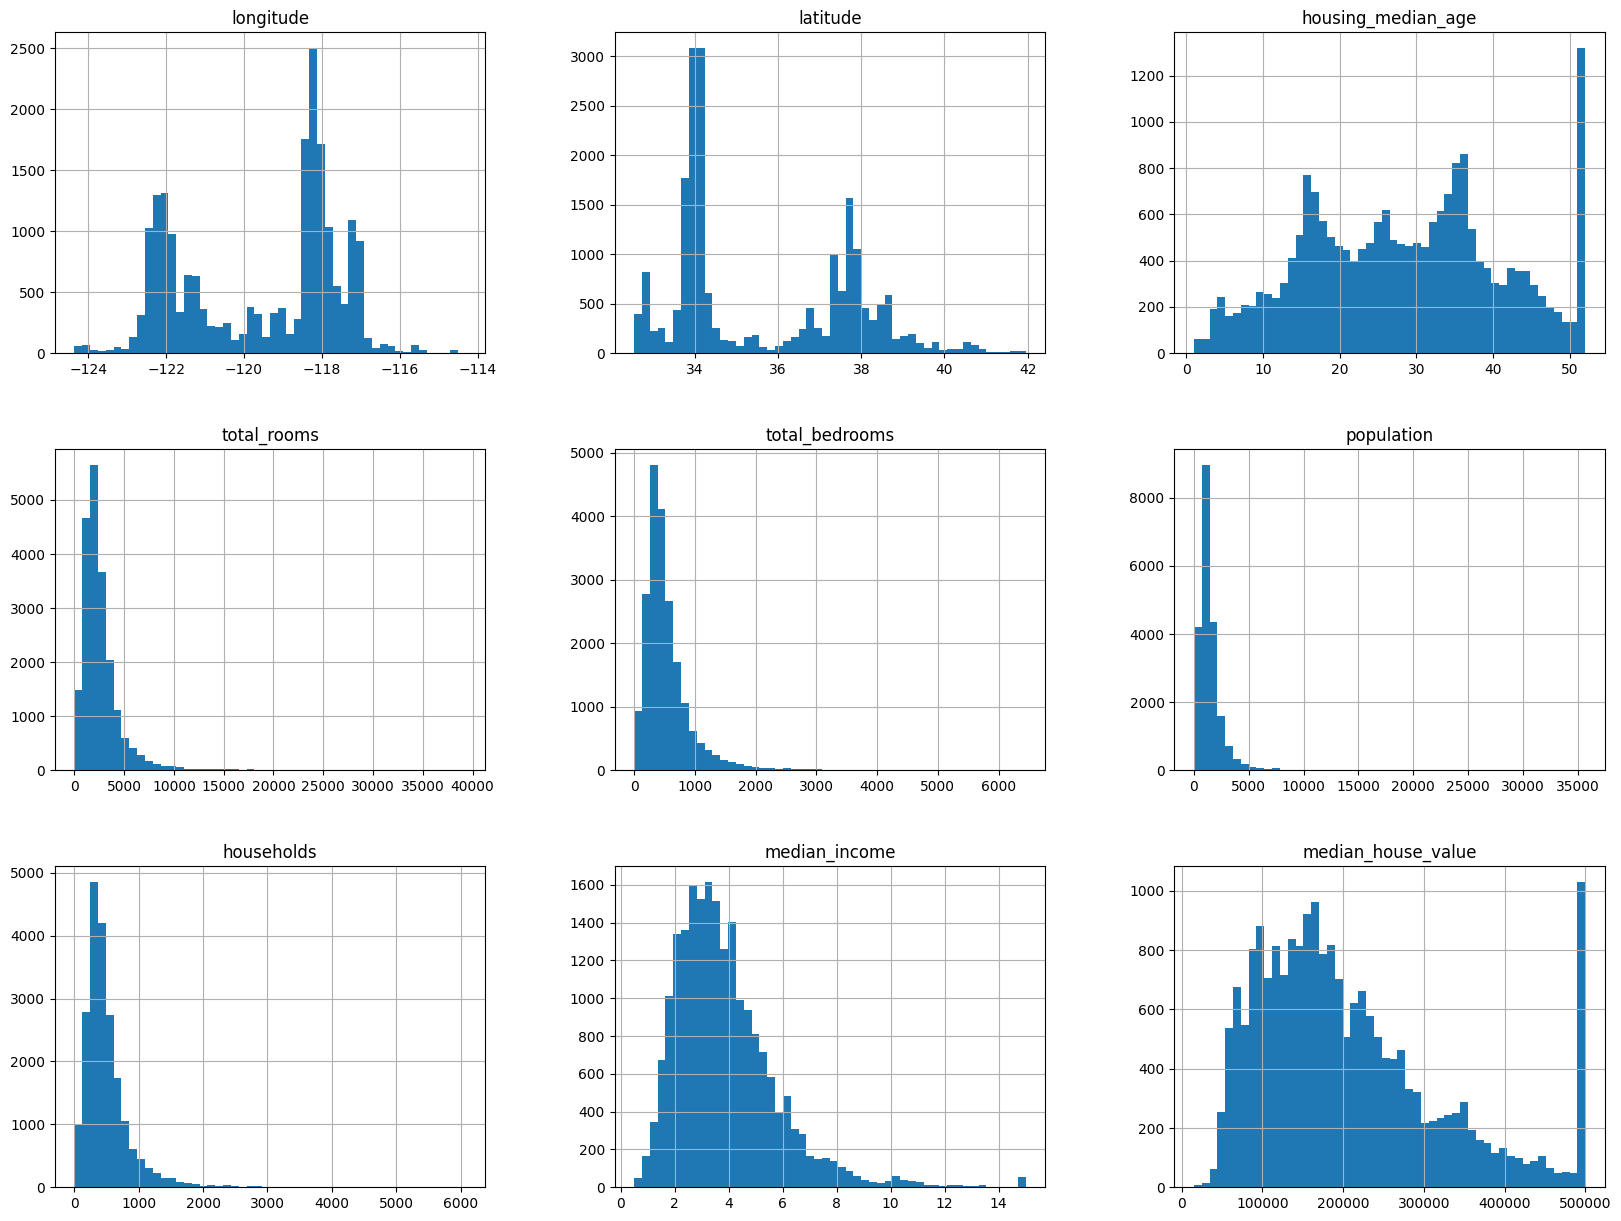

In [6]:
# Plot a histogram for each numerical attribute to get a feel for the data distribution
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

#### 🧑‍🏫 Theoretical Deep-Dive: Observations from Histograms

1.  **Capped Values:** The `housing_median_age` and `median_house_value` attributes are capped. The `median_house_value` (our target) being capped at $500,000 is a problem, as our model may learn that prices never go beyond that limit. We might need to remove these districts.
2.  **Different Scales:** The attributes have very different scales. This will be an issue for many ML algorithms, and we will need to address it with **feature scaling**.
3.  **Tail-Heavy Distributions:** Many histograms are *tail-heavy* (they extend much farther to the right). This can make it harder for algorithms to detect patterns. We may need to transform these attributes later (e.g., by computing their logarithm).

### 2.2. Create a Test Set

This is one of the most important steps. We must create a test set and set it aside *before* we do any more data exploration to avoid **data snooping bias**. This bias occurs when your brain (an amazing pattern-detection system) spots patterns in the test set, which can lead you to select a model that is biased towards the test set. Your model's generalization error will be too optimistic.

#### 🧑‍🏫 Theoretical Deep-Dive: Random vs. Stratified Sampling

If we use purely random sampling, we risk introducing **sampling bias**. For example, if our dataset is 51% female and 49% male, a purely random sample of 1,000 people might end up with 40% females, which is not representative.

To avoid this, we use **stratified sampling**. The population is divided into homogeneous subgroups called **strata**, and the right number of instances are sampled from each stratum to ensure the test set is representative of the overall population.

In our case, the `median_income` is a very important attribute. We need to ensure the test set is representative of the various income categories. We will create an `income_cat` attribute to perform stratified sampling.

In [7]:
# We will use Scikit-Learn's train_test_split for a simple random split
from sklearn.model_selection import train_test_split

# 'random_state' ensures the split is reproducible
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(f"Simple random split: {len(train_set)} train + {len(test_set)} test")

Simple random split: 16512 train + 4128 test


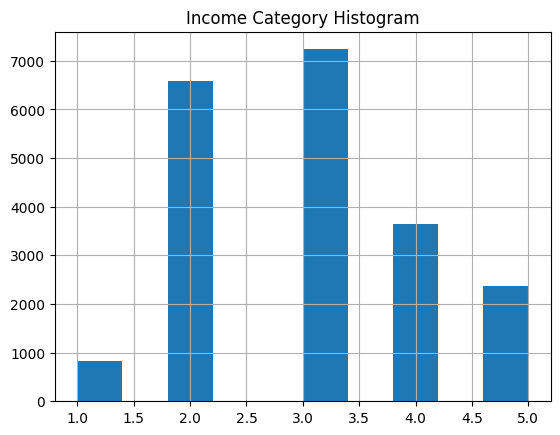

In [8]:
# Create an income category attribute with 5 categories
# pd.cut() creates 5 bins based on the specified ranges
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist()
plt.title("Income Category Histogram")
plt.show()

In [9]:
# Now perform stratified sampling based on the income category
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Check if the stratified split worked as expected
print("Income category proportions in test set (stratified):")
display(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

# Now we can drop the 'income_cat' column as it's no longer needed
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Income category proportions in test set (stratified):


,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


## 3. Discover and Visualize the Data to Gain Insights

Now that we have a clean training set (and our test set is safely locked away), we can explore the data. We'll work on a copy to avoid harming the original training set.

In [10]:
housing = strat_train_set.copy()

### 3.1. Visualizing Geographical Data

Since we have latitude and longitude, a scatterplot is a good way to visualize the data.

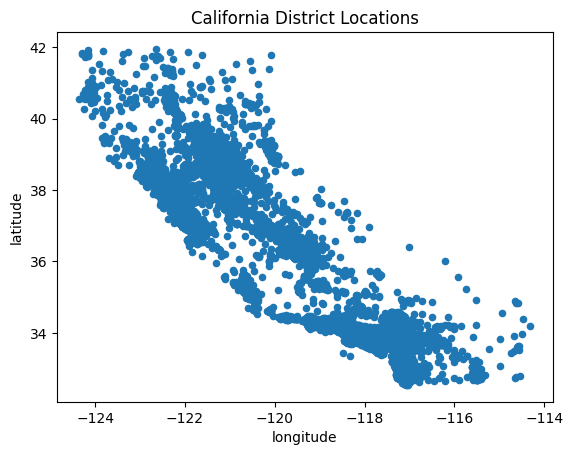

In [11]:
# Simple scatterplot
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.title("California District Locations")
plt.show()

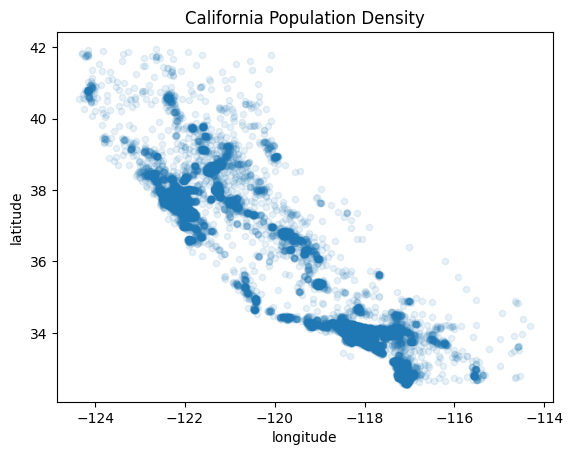

In [12]:
# Set alpha=0.1 to see density
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.title("California Population Density")
plt.show()

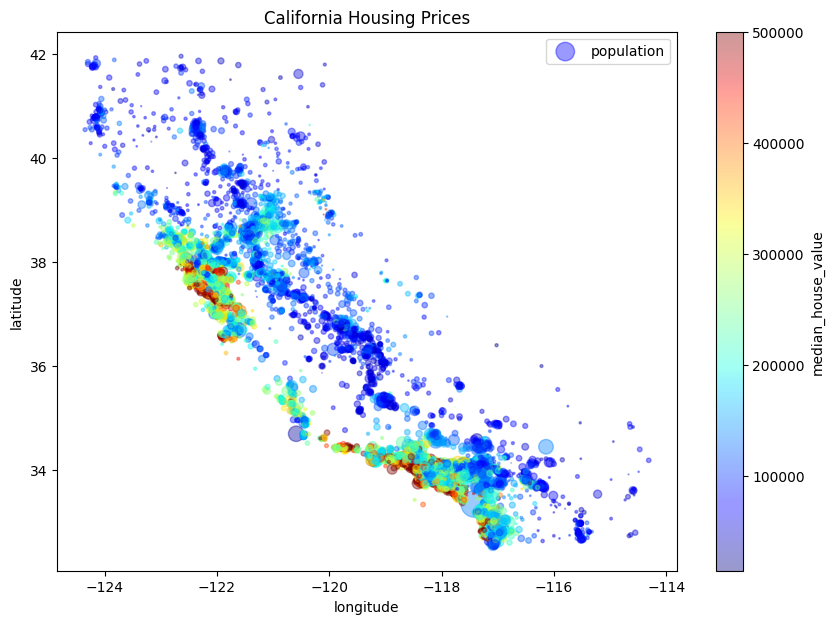

In [13]:
# Plot with population (s) and median house value (c)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
plt.title("California Housing Prices")
plt.show()

This image clearly shows that housing prices are very much related to location (e.g., close to the ocean and in high-density areas).

### 3.2. Looking for Correlations

Since the dataset is not too large, we can compute the **standard correlation coefficient** (Pearson's r) between every pair of attributes.

In [15]:
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()

# Check how much each attribute correlates with the median house value
print("Correlation with Median House Value:")
display(corr_matrix["median_house_value"].sort_values(ascending=False))

Correlation with Median House Value:


,median_house_value
median_house_value,1.000000
median_income,0.687151
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population,-0.026882
longitude,-0.047466
latitude,-0.142673


The `median_income` shows a strong positive correlation (0.68) with the `median_house_value`. This means that as median income goes up, median house prices tend to go up.

We can also use the `scatter_matrix` function from pandas to plot every numerical attribute against every other numerical attribute. We will focus on the most promising attributes.

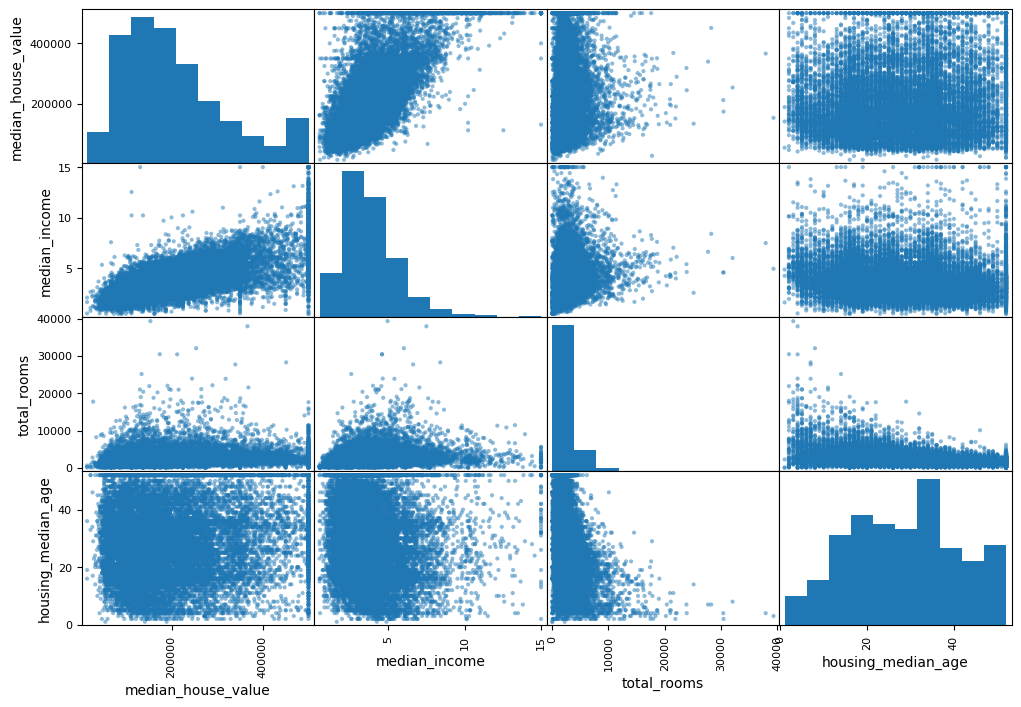

In [16]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

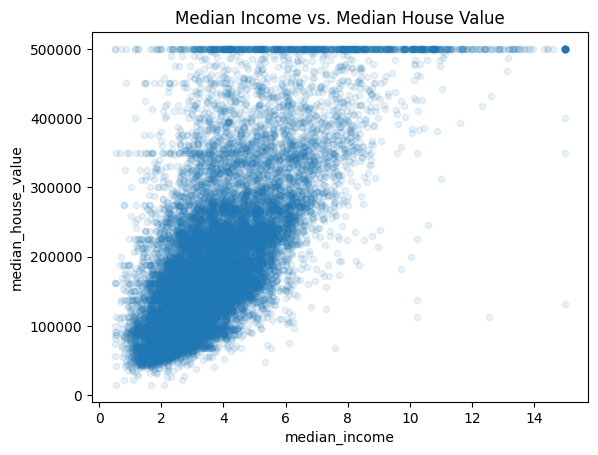

In [17]:
# Let's zoom in on the median_income vs median_house_value plot
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.title("Median Income vs. Median House Value")
plt.show()

This plot reveals a few things:
1.  The correlation is very strong.
2.  The price cap at $500,000 is clearly visible as a horizontal line.
3.  There are other, less obvious straight lines (e.g., at $450k, $350k). We may want to remove those districts to prevent the model from learning these quirks.

### 3.3. Experimenting with Attribute Combinations

The last step of data exploration is to try combining attributes to create new, potentially more useful features (feature engineering). For example, `total_rooms` is not very useful if we don't know the number of households. `rooms_per_household` is more informative.

In [19]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

# Let's look at the correlation matrix again
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()
print("Correlation with new features:")
display(corr_matrix["median_house_value"].sort_values(ascending=False))

Correlation with new features:


,median_house_value
median_house_value,1.000000
median_income,0.687151
rooms_per_household,0.146255
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population_per_household,-0.021991
population,-0.026882
longitude,-0.047466


Success! The new `bedrooms_per_room` attribute is much more correlated with the median house value than `total_rooms` or `total_bedrooms` (it's a negative correlation).

## 4. Prepare the Data for Machine Learning Algorithms

It's time to write functions to prepare the data. We do this for several reasons:
* To easily reproduce transformations on any dataset (e.g., the test set).
* To build a library of reusable transformation functions.
* To use these functions in our live system to transform new data.

First, let's revert to a clean training set and separate the predictors (`X`) from the labels (`y`).

In [20]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### 4.1. Data Cleaning

We need to handle the missing `total_bedrooms` features. We have three options:
1.  Get rid of the corresponding districts.
2.  Get rid of the whole attribute.
3.  Set the values to some value (zero, the mean, the median, etc.).

We will use option 3. Scikit-Learn provides a handy class to take care of this: `SimpleImputer`.

In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# The median can only be computed on numerical attributes, so we drop 'ocean_proximity'
housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)

# The imputer stores the median of each attribute in its 'statistics_' variable
print("Imputer medians:", imputer.statistics_)

# Now we can use the "trained" imputer to transform the training set
X = imputer.transform(housing_num)

# The result is a plain NumPy array. Let's put it back into a DataFrame.
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

Imputer medians: [-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


### 4.2. Handling Text and Categorical Attributes

We need to convert the `ocean_proximity` text attribute to numbers. Since it's a categorical attribute, we cannot use an `OrdinalEncoder` (which maps `"<1H OCEAN"` to 0, `"INLAND"` to 1, etc.) because ML algorithms will assume that two nearby values are more similar than two distant values (e.g., it would think 0 and 1 are more similar than 0 and 4).

The solution is **one-hot encoding**. This creates one binary attribute per category. A "<1H OCEAN" district would have a `1` in the "<1H OCEAN" column and `0`s in all other columns. We can use Scikit-Learn's `OneHotEncoder`.

In [22]:
from sklearn.preprocessing import OneHotEncoder

housing_cat = housing[["ocean_proximity"]] # Needs to be a 2D array
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

# The output is a SciPy sparse matrix (to save memory)
print("One-hot encoded data (sparse matrix):")
print(housing_cat_1hot.toarray())

One-hot encoded data (sparse matrix):
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


### 4.3. Custom Transformers

We need to create a custom transformer to add the combined attributes we experimented with earlier. We create a class that implements Scikit-Learn's required `fit()` and `transform()` methods. We use `BaseEstimator` and `TransformerMixin` for `get_params()` and `set_params()` methods, which are useful for hyperparameter tuning.

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

# Column indices for total_rooms, total_bedrooms, population, households
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
print("Data with extra attributes:")
print(housing_extra_attribs[0])

Data with extra attributes:
[-121.46 38.52 29.0 3873.0 797.0 2237.0 706.0 2.1736 'INLAND'
 5.485835694050992 3.168555240793201]


### 4.4. Feature Scaling and Transformation Pipelines

**Feature Scaling** is one of the most important transformations. ML algorithms don't perform well when numerical attributes have very different scales. There are two common methods:
* **Min-max scaling (Normalization):** Values are rescaled to range from 0 to 1. Use `MinMaxScaler`.
* **Standardization:** Values are rescaled to have a mean of 0 and a variance of 1. It is less affected by outliers. Use `StandardScaler`.

A **Pipeline** is a Scikit-Learn class that helps chain multiple transformation steps in the correct order. We will also use a `ColumnTransformer` to apply different transformations to different columns (e.g., `SimpleImputer` and `StandardScaler` for numbers, `OneHotEncoder` for categories).

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Create a pipeline for numerical attributes
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# Get list of numerical and categorical attribute names
housing_num = housing.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# Create a single pipeline that handles all columns
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# Run the full pipeline
housing_prepared = full_pipeline.fit_transform(housing)

print("Shape of prepared data:", housing_prepared.shape)
print("One row of prepared data:", housing_prepared[0])

Shape of prepared data: (16512, 16)
One row of prepared data: [-0.94135046  1.34743822  0.02756357  0.58477745  0.64037127  0.73260236
  0.55628602 -0.8936472   0.01739526  0.00622264 -0.12112176  0.
  1.          0.          0.          0.        ]


## 5. Select and Train a Model

We are finally ready to train some models! We'll start with a few simple ones.

### 5.1. Training a Linear Regression Model

Let's first train a simple Linear Regression model.

In [25]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# Let's try it on a few instances from the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [26]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Linear Regression RMSE:", lin_rmse)


Linear Regression RMSE: 68627.87390018745


An RMSE of $68,628 is not great. This is a clear sign that the model is **underfitting** the training data. This means the features don't provide enough information, or the model is not powerful enough.

### 5.2. Training a Decision Tree Regressor

Let's try a more powerful model, a `DecisionTreeRegressor`.

In [27]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print("Decision Tree RMSE:", tree_rmse)

Decision Tree RMSE: 0.0


An RMSE of 0.0 means the model **overfit** the data perfectly. This is not a useful model. We can't touch the test set yet, so we need a way to evaluate the model on the training set. The solution is **K-fold cross-validation**.

### 5.3. Better Evaluation Using Cross-Validation

**K-fold cross-validation** randomly splits the training set into K distinct subsets (e.g., 10), then it trains and evaluates the model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array of 10 evaluation scores.

**Note:** Scikit-Learn's cross-validation features expect a *utility function* (greater is better) rather than a *cost function* (lower is better), so it computes the *negative* MSE. We must flip the sign of the scores before calculating the square root.

In [28]:
from sklearn.model_selection import cross_val_score

# Evaluate the Decision Tree model
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

print("--- Decision Tree Cross-Validation ---")
display_scores(tree_rmse_scores)

# Now let's evaluate the Linear Regression model for comparison
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

print("\n--- Linear Regression Cross-Validation ---")
display_scores(lin_rmse_scores)

--- Decision Tree Cross-Validation ---
Scores: [73478.93445334 71177.03240802 67743.70585898 71756.7898617
 70679.35946705 77665.00371384 69940.4756534  72577.41873779
 67510.16800402 71623.20528029]
Mean: 71415.20934384217
Standard deviation: 2762.822645170709

--- Linear Regression Cross-Validation ---
Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180694


The Decision Tree model is overfitting so badly that it performs worse (mean RMSE ~71,407) than the Linear Regression model (mean RMSE ~69,052).

### 5.4. Training a Random Forest Regressor

Let's try one last model: `RandomForestRegressor`. This is an **Ensemble Learning** method that works by training many Decision Trees on random subsets of the features, then averaging their predictions. Ensembles often perform better than individual models.

In [29]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
# Note: The book trains the model first, then does cross-validation. We'll just do cross-validation.

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print("--- Random Forest Cross-Validation ---")
display_scores(forest_rmse_scores)

--- Random Forest Cross-Validation ---
Scores: [51352.69992678 48681.33944626 46768.59849642 51772.21495576
 47174.3299129  51450.77911937 52168.22464155 49622.8176267
 48550.82248556 53751.84504217]
Mean: 50129.367165346244
Standard deviation: 2193.0138727802228


This is much better! The mean RMSE is around 50,000. This is our most promising model so far. Note that the training score would still be much lower than the validation score, meaning the model is still overfitting, but it's a good starting point.

## 6. Fine-Tune Your Model

We now have a shortlist of promising models. The next step is to fine-tune them. We will focus on the `RandomForestRegressor`.

### 6.1. Grid Search

One way to fine-tune is to fiddle with hyperparameters manually, but this is tedious. A better way is to use Scikit-Learn's `GridSearchCV`. You tell it which hyperparameters and values to try, and it uses cross-validation to evaluate all possible combinations and find the best one.

In [30]:
from sklearn.model_selection import GridSearchCV

# This param_grid tells GridSearchCV to evaluate 3 x 4 = 12 combinations from the first dict,
# then 2 x 3 = 6 combinations from the second dict (with bootstrap=False)
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [31]:
# Get the best combination of parameters
print("Best parameters found by Grid Search:")
print(grid_search.best_params_)

Best parameters found by Grid Search:
{'max_features': 6, 'n_estimators': 30}


In [32]:
# Get the best estimator (model)
print("\nBest estimator:")
print(grid_search.best_estimator_)


Best estimator:
RandomForestRegressor(max_features=6, n_estimators=30)


In [33]:
# Get the evaluation scores
cvres = grid_search.cv_results_
print("\nScores for each combination:")
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


Scores for each combination:
64655.87793544256 {'max_features': 2, 'n_estimators': 3}
55353.1973201068 {'max_features': 2, 'n_estimators': 10}
52895.35706253509 {'max_features': 2, 'n_estimators': 30}
60908.09056637888 {'max_features': 4, 'n_estimators': 3}
52759.22544291731 {'max_features': 4, 'n_estimators': 10}
50763.79484143965 {'max_features': 4, 'n_estimators': 30}
58667.543799221894 {'max_features': 6, 'n_estimators': 3}
51898.85764918415 {'max_features': 6, 'n_estimators': 10}
49800.70401788082 {'max_features': 6, 'n_estimators': 30}
58952.50793081773 {'max_features': 8, 'n_estimators': 3}
52111.7094682527 {'max_features': 8, 'n_estimators': 10}
49919.09980433617 {'max_features': 8, 'n_estimators': 30}
61768.00825031179 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54205.0533723941 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60276.31949749282 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52378.663491990854 {'bootstrap': False, 'max_fea

The best model has an RMSE of 49,682, which is slightly better than the 50,182 we got earlier with the default hyperparameters.

### 6.2. Randomized Search

When the hyperparameter search space is large, `GridSearchCV` is too slow. `RandomizedSearchCV` is a better option. It evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

### 6.3. Analyze the Best Models and Their Errors

We can gain insights by inspecting the best models. For example, `RandomForestRegressor` can indicate the relative importance of each attribute.

In [34]:
feature_importances = grid_search.best_estimator_.feature_importances_

# Get the attribute names (a bit tricky with ColumnTransformer)
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

print("Feature Importances:")
sorted(zip(feature_importances, attributes), reverse=True)

Feature Importances:


[(np.float64(0.3039389756178018), 'median_income'),
 (np.float64(0.1467629816507307), 'INLAND'),
 (np.float64(0.11110651134774929), 'bedrooms_per_room'),
 (np.float64(0.10699699829658066), 'pop_per_hhold'),
 (np.float64(0.07734465930275182), 'longitude'),
 (np.float64(0.0719735453025661), 'latitude'),
 (np.float64(0.049710566287893915), 'rooms_per_hhold'),
 (np.float64(0.04108920348673833), 'housing_median_age'),
 (np.float64(0.017805606052993465), 'total_rooms'),
 (np.float64(0.01776688439622131), 'population'),
 (np.float64(0.016900933857891567), 'households'),
 (np.float64(0.016067761282917276), 'total_bedrooms'),
 (np.float64(0.012921281696756617), '<1H OCEAN'),
 (np.float64(0.005370214539445999), 'NEAR OCEAN'),
 (np.float64(0.00418159945464304), 'NEAR BAY'),
 (np.float64(6.227742631822008e-05), 'ISLAND')]

With this information, we might want to try dropping some of the less useful features (e.g., the `ISLAND` ocean_proximity category).

## 7. Evaluate Your System on the Test Set

After tweaking models for a while, we finally have a model that performs well. Now is the time to evaluate the final model on the test set.

**Important:** We must call `transform()` on the test set, *not* `fit_transform()`. We do not want to fit the test set.

In [35]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("Final RMSE on Test Set:", final_rmse)

Final RMSE on Test Set: 48050.921812196284


## 8. Launch, Monitor, and Maintain Your System

This is the final step, which is just as important as the previous ones.
* **Result:** The RMSE of $48,051 is not excessively large when considered against the typical `median_house_value` (up to \$48,051 is not excessively large when considered against the typical `median_house_value` (up to \$500,000), indicating a reasonable average prediction error that also shows significant improvement over simpler models.
* **Launch:** Get your solution ready for production. This involves polishing the code, writing documentation and tests, and deploying the model (e.g., as a web service).
* **Monitor:** You need to write monitoring code to check your system's live performance. Models "rot" over time as data evolves, so you must monitor for performance degradation.
* **Maintain:** You need to have processes in place to retrain your model on fresh data, evaluate it, and deploy it (automating as much as possible).